<a href="https://colab.research.google.com/github/MassimilianoArmato/Neural-Networks/blob/main/Armato_Grosso_Project_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CLASSIFICATORE DI TIPOLOGIE DI AUTOMOBILI**
Autori: Armato Massimiliano e Grosso Martina

Importiamo le librerie.

In [ ]:
import torch
from torch import nn
from torch import optim
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import torchvision

import numpy as np

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)

cpu


Importiamo il dataset da Kaggle.

In [ ]:
!pip install kaggle

In [ ]:
! kaggle datasets download kshitij192/cars-image-dataset --force

Dataset URL: https://www.kaggle.com/datasets/kshitij192/cars-image-dataset
License(s): GPL-2.0
 85% 31.0M/36.3M [00:00<00:00, 78.9MB/s]
100% 36.3M/36.3M [00:00<00:00, 66.7MB/s]


In [ ]:
! unzip /content/cars-image-dataset.zip

Archive:  /content/cars-image-dataset.zip
  inflating: Cars Dataset/test/Audi/1000.jpg  
  inflating: Cars Dataset/test/Audi/1003.jpg  
  inflating: Cars Dataset/test/Audi/1008.jpg  
  inflating: Cars Dataset/test/Audi/1020.jpg  
  inflating: Cars Dataset/test/Audi/1022.jpg  
  inflating: Cars Dataset/test/Audi/1025.jpg  
  inflating: Cars Dataset/test/Audi/1027.jpg  
  inflating: Cars Dataset/test/Audi/1038.jpg  
  inflating: Cars Dataset/test/Audi/104.jpg  
  inflating: Cars Dataset/test/Audi/1043.jpg  
  inflating: Cars Dataset/test/Audi/1051.jpg  
  inflating: Cars Dataset/test/Audi/1059.jpg  
  inflating: Cars Dataset/test/Audi/1060.jpg  
  inflating: Cars Dataset/test/Audi/1064.jpg  
  inflating: Cars Dataset/test/Audi/1066.jpg  
  inflating: Cars Dataset/test/Audi/1072.jpg  
  inflating: Cars Dataset/test/Audi/1073.jpg  
  inflating: Cars Dataset/test/Audi/1080.jpg  
  inflating: Cars Dataset/test/Audi/1084.jpg  
  inflating: Cars Dataset/test/Audi/1085.jpg  
  inflating: Cars D

In [ ]:
! rm -r /content/Cars\ Dataset/test/Hyundai\ Creta
! rm -r /content/Cars\ Dataset/test/Mahindra\ Scorpio
! rm -r /content/Cars\ Dataset/test/Rolls\ Royce
! rm -r /content/Cars\ Dataset/train/Hyundai\ Creta
! rm -r /content/Cars\ Dataset/train/Mahindra\ Scorpio
! rm -r /content/Cars\ Dataset/train/Rolls\ Royce

In [ ]:
import os
from PIL import Image, ImageFile

ImageFile.LOAD_TRUNCATED_IMAGES = False   # attempting to load truncated images will result in an error

def is_not_truncated(file_path):
  try:
    # Attempt to open and load the image file
    with Image.open(file_path) as img:
      img.load()
      return True        # Image file is not truncated
  except OSError:
    return False         # Image file is truncated or cannot be opened


In [ ]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

n = 64

transform = transforms.Compose([
    transforms.Resize((n, n)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

train_dataset = datasets.ImageFolder('/content/Cars Dataset/train',
                                     transform=transform,
                                     is_valid_file = is_not_truncated)

val_dataset = datasets.ImageFolder('/content/Cars Dataset/test', transform=transform, is_valid_file = is_not_truncated)

batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last = True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, drop_last = True)


Visualizzazione di alcuni esempi di immagini del dataset per ciascuna classe.

<Figure size 640x480 with 0 Axes>

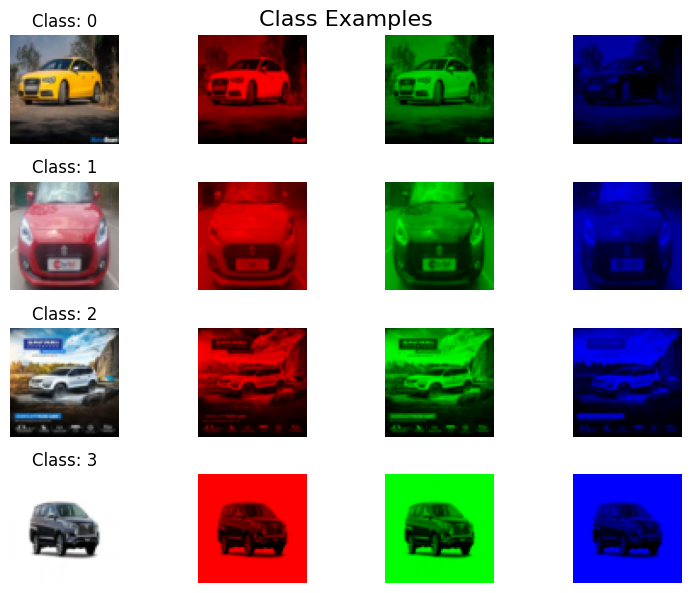

In [ ]:
from google.colab import files
fig_class_exemples = plt.figure()

import copy

class_examples = {} # Dizionario per tenere traccia delle immagini per ogni classe


for batch_idx, (example_data, example_targets) in enumerate(train_loader): # Itera attraverso il train_loader fino a trovare un esempio per ogni classe
    for i in range(len(example_targets)):
        label = example_targets[i].item()
        if label not in class_examples:
            class_examples[label] = example_data[i]


        if len(class_examples) == 4: # Se abbiamo già trovato tutte le 4 classi, possiamo interrompere la ricerca
            break
    if len(class_examples) == 4:
        break

num_classes = 4
num_cols = 4

fig, axes = plt.subplots(num_classes, num_cols, figsize=(8, 6))


sorted_classes = sorted(class_examples.keys()) # Ordina le classi

for i, label in enumerate(sorted_classes):
    img = class_examples[label]
    img = img.swapaxes(0, 1).swapaxes(1, 2) * 0.5 + 0.5

    r = copy.deepcopy(img)
    r[:, :, 1] = r[:, :, 2] = 0

    g = copy.deepcopy(img)
    g[:, :, 0] = g[:, :, 2] = 0

    b = copy.deepcopy(img)
    b[:, :, 1] = b[:, :, 0] = 0

    axes[i, 0].imshow(img)
    axes[i, 1].imshow(r)
    axes[i, 2].imshow(g)
    axes[i, 3].imshow(b)

    axes[i, 0].set_title("Class: {}".format(label))

    for j in range(num_cols):
        axes[i, j].axis('off')

plt.tight_layout()
fig.suptitle('Class Examples', fontsize= 16 )
#plt.savefig('fig_class_exemples.pdf')
#files.download('fig_class_exemples.pdf')
plt.show()


# **Modello rete shallow**

In [ ]:
class shallow(nn.Module):
    def __init__(self):
        super().__init__()
        # Adjust dropout probability as needed

        self.fc1 = nn.Linear(n*n*3, 16)
        self.fc2 = nn.Linear(16, 4)
        self.activation = nn.ReLU()
        self.output = nn.Softmax(dim = 1)

    def reset_weights(self): #per resettare i pesi prima di ogni richiamo (distribuzione uniforme)
      torch.nn.init.xavier_uniform_(self.fc1.weight)
      torch.nn.init.xavier_uniform_(self.fc2.weight)

    def forward(self, x):


        x = torch.flatten(x, 1)


        x = self.activation(self.fc1(x))
        x= self.fc2(x)

        return self.output(x)

model = shallow().to(device)

if device.type == "cuda:0":
  model = torch.compile(model, dynamic=True)
  model = model.to(device)
else:
  model = torch.compile(model, mode = "max-autotune-no-cudagraphs", dynamic=True)

# **Modello FC**

In [ ]:
class FC(nn.Module):
    def __init__(self):
        super().__init__()


        self.dropout = nn.Dropout(p=0.2)
        self.activation = nn.ReLU()
        self.fc1 = nn.Linear(n*n*3, 500)
        self.fc2 = nn.Linear(500, 200)
        self.fc3 = nn.Linear(200, 100)
        self.fc4 = nn.Linear(100, 16)
        self.fc5 = nn.Linear(16, 4)

        self.output = nn.Softmax(dim = 1)

    def reset_weights(self): #per resettare i pesi prima di ogni richiamo (distribuzione uniforme)
      torch.nn.init.xavier_uniform_(self.fc1.weight)
      torch.nn.init.xavier_uniform_(self.fc2.weight)
      torch.nn.init.xavier_uniform_(self.fc3.weight)
      torch.nn.init.xavier_uniform_(self.fc4.weight)
      torch.nn.init.xavier_uniform_(self.fc5.weight)

    def forward(self, x):


        x = torch.flatten(x, 1)

        x = self.activation(self.fc1(x))
        x = self.dropout(x)
        x = self.activation(self.fc2(x))
        x = self.dropout(x)
        x = self.activation(self.fc3(x))
        x = self.dropout(x)
        x = self.activation(self.fc4(x))
        x = self.dropout(x)
        x = self.fc5(x)

        return self.output(x)

model1 = FC().to(device)

if device.type == "cuda:0":
  model1 = torch.compile(model1, dynamic=True)
  model1 = model1.to(device)
else:
  model1 = torch.compile(model1, mode = "max-autotune-no-cudagraphs", dynamic=True)

# **Modello CNN**

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 16, kernel_size=(5,5), stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 16, kernel_size=(5,5), stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(16, 16, kernel_size=(5,5), stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(16)

        self.activation = nn.ReLU()
        self.pooling = nn.MaxPool2d(kernel_size=2, stride=2)

        self.dropout = nn.Dropout(p=0.2)

        self.fc1 = nn.Linear((n-16)**2//4, 16)
        self.fc2 = nn.Linear(16, 4)

        self.output = nn.Softmax(dim = 1)

    def reset_weights(self): #per resettare i pesi prima di ogni richiamo (distribuzione uniforme)
      torch.nn.init.xavier_uniform_(self.fc1.weight)
      torch.nn.init.xavier_uniform_(self.fc2.weight)

    def forward(self, x):


        x = self.activation(self.bn1(self.conv1(x)))
        x = self.pooling(x)
        x = self.dropout(x)

        x = self.activation(self.bn2(self.conv2(x)))
        x = self.pooling(x)
        x = self.dropout(x)

        x = self.activation(self.bn3(self.conv3(x)))
        x = self.pooling(x)
        x = self.dropout(x)

        x = torch.flatten(x, 1)

        x = self.activation(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return self.output(x)

model2 = CNN().to(device)

if device.type == "cuda:0":
  model2 = torch.compile(model2, dynamic=True)
  model2 = model2.to(device)
else:
  model2 = torch.compile(model2, mode = "max-autotune-no-cudagraphs", dynamic=True)

In [ ]:
loss_function = nn.CrossEntropyLoss()

In [ ]:
def accuracy(y_pred, y):

  pred = y_pred.detach().argmax(dim=1)
  corrects = (pred == y)

  accuracy = (corrects.sum()/corrects.size(0)).float()

  return accuracy

def loader_accuracy(model, loader):

  with torch.no_grad():

    acc = 0

    for x, y in loader:

      x, y = x.to(device), y.to(device)

      acc += accuracy(model(x).squeeze(), y)

    return (acc/len(loader)*100).cpu()

def step(model, x, y, optimizer = None):

  out = model(x)
  loss = loss_function(out.squeeze(), y.long())

  if optimizer is not None:

    optimizer.zero_grad()
    loss.backward()

    optimizer.step()

  return loss.detach().cpu()

def evaluate(model, loader, early_stopping = None):

  with torch.no_grad():

    loss = 0


    for inputs, targets in loader:

      inputs, targets = inputs.to(device), targets.to(device)
      loss += step(model, inputs, targets)

    loss /= len(loader)

   # Check for early stopping
    if early_stopping is not None:
      early_stopping(loss, model)

    return loss.detach().cpu()


if device.type != "cpu":
  accuracy = torch.compile(accuracy)
  train = torch.compile(step)
else:
  accuracy = torch.compile(accuracy, mode = "max-autotune-no-cudagraphs", dynamic=True)
  train = torch.compile(step, mode = "max-autotune-no-cudagraphs", dynamic=True)


# Early stopping

In [ ]:
# this code is taken from https://github.com/Bjarten/early-stopping-pytorch
# Copyright (c) 2018 Bjarte Mehus Sunde under MIT License
# to see full license consult the NOTICE.txt file on the Github repository from which this notebook is taken from

class EarlyStopping:
  def __init__(self, patience=5, delta=0, verbose=False, path='checkpoint.pt'):
    self.patience = patience       # Number of epochs to wait for improvement
    self.delta = delta             # Minimum change in monitored metric to qualify as improvement
    self.verbose = verbose         # If True, print a message when validation metric improves
    self.path = path               # Path to save the model checkpoint
    self.counter = 0               # Counter to track epochs without improvement
    self.best_score = None         # Best validation metric achieved so far
    self.early_stop = False        # Flag to indicate whether to stop training

  def __call__(self, val_metric, model):
    if self.best_score is None:
      self.best_score = val_metric
      self.save_checkpoint(model)
    elif val_metric > self.best_score + self.delta:
      self.counter += 1
      if self.verbose:
        print(f'Epochs without improvement: {self.counter}')
      if self.counter >= self.patience:
                self.early_stop = True
    else:
      self.best_score = val_metric
      self.save_checkpoint(model)
      self.counter = 0

  def save_checkpoint(self, model):
    torch.save(model.state_dict(), self.path)


In [ ]:
! mkdir /content/.checkpoints

mkdir: cannot create directory ‘/content/.checkpoints’: File exists


# **Scelta learning rate rete shallow**

In [ ]:
def train_model(lrs = [0.01], max_epochs = 100):

  results = []

  for learning_rate in lrs:

    print("Starting with lr:", learning_rate)
    model = shallow().to(device)

    if device.type == "cuda:0":
      model = torch.compile(model, dynamic=True)
      model = model.to(device)
    else:
      model = torch.compile(model, mode = "max-autotune-no-cudagraphs", dynamic=True)

    optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

    early_stopping = EarlyStopping(patience=4, verbose=False, path=f'/content/.checkpoints/model_checkpoint_{learning_rate}.pt')

    for epoch in range(max_epochs):

      ## TRAIN STEP

      model.train()

      for x_train, y_train in train_loader:

        x_train, y_train = x_train.to(device), y_train.to(device)
        step(model, x_train, y_train, optimizer)

      ## TEST STEP

      model.eval()

      val_loss = evaluate(model, val_loader, early_stopping)

      if early_stopping.early_stop:
          break

    model.load_state_dict(torch.load(f'/content/.checkpoints/model_checkpoint_{learning_rate}.pt'))

    train_acc = loader_accuracy(model, train_loader)
    val_acc = loader_accuracy(model, val_loader)

    train_loss = evaluate(model, train_loader)
    val_loss = evaluate(model, val_loader)

    results.append([train_loss, val_loss, train_acc, val_acc])
    print(f"\tTrain loss: {train_loss:.3f} and validation loss: {val_loss:.3f}\n\tTrain accuracy: {train_acc:.2f}% and valiation accuracy: {val_acc:.2f}%\n\n")
    model.reset_weights() # reset dei pesi prima di andare al learning rate successivo
  return results

In [ ]:
lrs0=[0.05,0.06,0.07,0.08,0.09]
results = train_model(lrs0, max_epochs = 20)

Starting with lr: 0.05
	Train loss: 0.894 and validation loss: 1.060
	Train accuracy: 86.10% and valiation accuracy: 68.40%


Starting with lr: 0.06
	Train loss: 0.886 and validation loss: 1.071
	Train accuracy: 86.64% and valiation accuracy: 66.15%


Starting with lr: 0.07
	Train loss: 0.887 and validation loss: 1.065
	Train accuracy: 86.64% and valiation accuracy: 67.01%


Starting with lr: 0.08
	Train loss: 0.883 and validation loss: 1.077
	Train accuracy: 86.43% and valiation accuracy: 65.45%


Starting with lr: 0.09
	Train loss: 0.876 and validation loss: 1.062
	Train accuracy: 86.84% and valiation accuracy: 68.06%




In [ ]:
results0 = results

In [ ]:
results0 = np.array(results0).T

<Figure size 640x480 with 0 Axes>

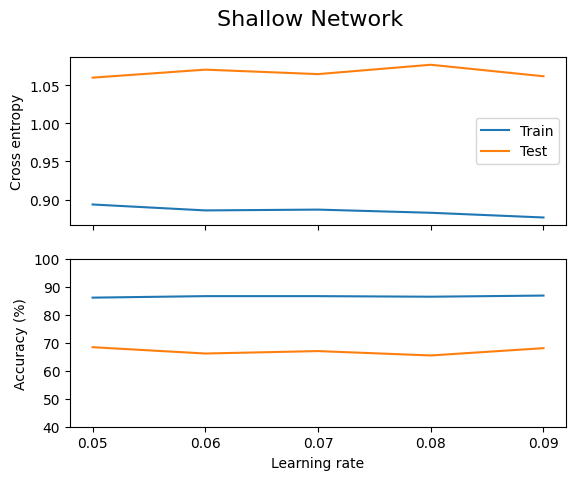

In [ ]:
shallow_cross_accuracy = plt.figure()
fig, ax = plt.subplots(nrows=2, ncols=1, sharex = True)

ax[0].plot(lrs0, results0[0], label = "Train")
ax[0].plot(lrs0, results0[1], label = "Test")

ax[0].legend()

ax[0].set_ylabel("Cross entropy")

ax[1].plot(lrs0, results0[2], label = "Train")
ax[1].plot(lrs0, results0[3], label = "Test")


ax[1].set_xlabel("Learning rate")
ax[1].set_ylabel("Accuracy (%)")

ax[1].set_xticks(lrs0)


ax[1].set(ylim=(40, 100))

fig.suptitle("Shallow Network", fontsize=16)
"""
plt.savefig('shallow_cross_accuracy.pdf')
files.download('shallow_cross_accuracy.pdf')"""

plt.show()


# **Scelta learning rate rete FC**

In [ ]:
def train_model1(lrs = [0.01], max_epochs = 100):

  results = []

  for learning_rate in lrs:

    print("Starting with lr:", learning_rate)
    model1 = FC().to(device)

    if device.type == "cuda:0":
      model1 = torch.compile(model1, dynamic=True)
      model1 = model1.to(device)
    else:
      model1 = torch.compile(model1, mode = "max-autotune-no-cudagraphs", dynamic=True)

    optimizer = torch.optim.SGD(model1.parameters(), lr = learning_rate)

    early_stopping = EarlyStopping(patience=4, verbose=False, path=f'/content/.checkpoints/model_checkpoint_{learning_rate}.pt')

    for epoch in range(max_epochs):

      ## TRAIN STEP

      model1.train()

      for x_train, y_train in train_loader:

        x_train, y_train = x_train.to(device), y_train.to(device)
        step(model1, x_train, y_train, optimizer)

      ## TEST STEP

      model1.eval()

      val_loss = evaluate(model1, val_loader, early_stopping)

      if early_stopping.early_stop:
          break

    model1.load_state_dict(torch.load(f'/content/.checkpoints/model_checkpoint_{learning_rate}.pt'))

    train_acc = loader_accuracy(model1, train_loader)
    val_acc = loader_accuracy(model1, val_loader)

    train_loss = evaluate(model1, train_loader)
    val_loss = evaluate(model1, val_loader)

    results.append([train_loss, val_loss, train_acc, val_acc])
    print(f"\tTrain loss: {train_loss:.3f} and validation loss: {val_loss:.3f}\n\tTrain accuracy: {train_acc:.2f}% and valiation accuracy: {val_acc:.2f}%\n\n")
    model1.reset_weights() # reset dei pesi prima di andare al learning rate successivo
  return results

In [ ]:
lrs1 = [0.05,0.1,0.15,0.2, 0.3]
results = train_model1(lrs1, max_epochs = 20)

Starting with lr: 0.05
	Train loss: 1.115 and validation loss: 1.209
	Train accuracy: 61.27% and valiation accuracy: 51.74%


Starting with lr: 0.1
	Train loss: 0.968 and validation loss: 1.109
	Train accuracy: 77.30% and valiation accuracy: 62.67%


Starting with lr: 0.15
	Train loss: 1.108 and validation loss: 1.177
	Train accuracy: 63.16% and valiation accuracy: 55.90%


Starting with lr: 0.2
	Train loss: 1.057 and validation loss: 1.137
	Train accuracy: 68.59% and valiation accuracy: 59.38%


Starting with lr: 0.3
	Train loss: 1.125 and validation loss: 1.215
	Train accuracy: 61.47% and valiation accuracy: 52.78%




In [ ]:
results1 = results

In [ ]:
results1 = np.array(results1).T

<Figure size 640x480 with 0 Axes>

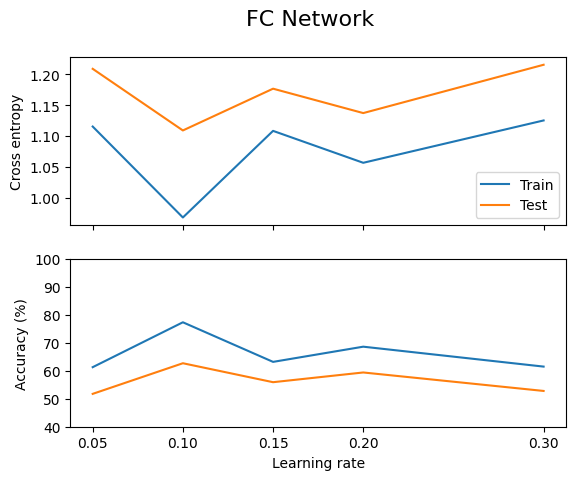

In [ ]:
fc_cross_accuracy = plt.figure()
fig, ax = plt.subplots(nrows=2, ncols=1, sharex = True)

ax[0].plot(lrs1, results1[0], label = "Train")
ax[0].plot(lrs1, results1[1], label = "Test")

ax[0].legend()

ax[0].set_ylabel("Cross entropy")

ax[1].plot(lrs1, results1[2], label = "Train")
ax[1].plot(lrs1, results1[3], label = "Test")


ax[1].set_xlabel("Learning rate")
ax[1].set_ylabel("Accuracy (%)")

ax[1].set_xticks(lrs1)


ax[1].set(ylim=(40, 100))

fig.suptitle("FC Network", fontsize=16)
"""
plt.savefig('fc_cross_accuracy.pdf')
files.download('fc_cross_accuracy.pdf')"""

plt.show()

# **Scelta learning rate rete CNN**

In [ ]:
def train_model2(lrs = [0.01], max_epochs = 100):

  results = []

  for learning_rate in lrs:

    print("Starting with lr:", learning_rate)
    model2 = CNN().to(device)

    if device.type == "cuda:0":
      model2 = torch.compile(model2, dynamic=True)
      model2 = model2.to(device)
    else:
      model2 = torch.compile(model2, mode = "max-autotune-no-cudagraphs", dynamic=True)

    optimizer = torch.optim.SGD(model2.parameters(), lr = learning_rate)

    early_stopping = EarlyStopping(patience=4, verbose=False, path=f'/content/.checkpoints/model_checkpoint_{learning_rate}.pt')

    for epoch in range(max_epochs):

      ## TRAIN STEP

      model2.train()

      for x_train, y_train in train_loader:

        x_train, y_train = x_train.to(device), y_train.to(device)
        step(model2, x_train, y_train, optimizer)

      ## TEST STEP

      model2.eval()

      val_loss = evaluate(model2, val_loader, early_stopping)

      if early_stopping.early_stop:
          break

    model2.load_state_dict(torch.load(f'/content/.checkpoints/model_checkpoint_{learning_rate}.pt'))

    train_acc = loader_accuracy(model2, train_loader)
    val_acc = loader_accuracy(model2, val_loader)

    train_loss = evaluate(model2, train_loader)
    val_loss = evaluate(model2, val_loader)

    results.append([train_loss, val_loss, train_acc, val_acc])
    print(f"\tTrain loss: {train_loss:.3f} and validation loss: {val_loss:.3f}\n\tTrain accuracy: {train_acc:.2f}% and valiation accuracy: {val_acc:.2f}%\n\n")
    model2.reset_weights() # reset dei pesi prima di andare al learning rate successivo
  return results

In [ ]:
lrs2 = [0.1,0.2,0.3, 0.4, 0.5,0.6]
results = train_model2(lrs2, max_epochs = 20)

Starting with lr: 0.1
	Train loss: 0.975 and validation loss: 1.036
	Train accuracy: 76.69% and valiation accuracy: 70.31%


Starting with lr: 0.2
	Train loss: 0.912 and validation loss: 0.982
	Train accuracy: 83.06% and valiation accuracy: 75.87%


Starting with lr: 0.3
	Train loss: 0.960 and validation loss: 1.003
	Train accuracy: 78.87% and valiation accuracy: 73.78%


Starting with lr: 0.4
	Train loss: 1.002 and validation loss: 1.051
	Train accuracy: 73.73% and valiation accuracy: 68.23%


Starting with lr: 0.5
	Train loss: 1.000 and validation loss: 1.058
	Train accuracy: 73.89% and valiation accuracy: 67.88%


Starting with lr: 0.6
	Train loss: 0.998 and validation loss: 1.057
	Train accuracy: 74.59% and valiation accuracy: 68.23%




In [ ]:
results2 = results

In [ ]:
results2 = np.array(results2).T

<Figure size 640x480 with 0 Axes>

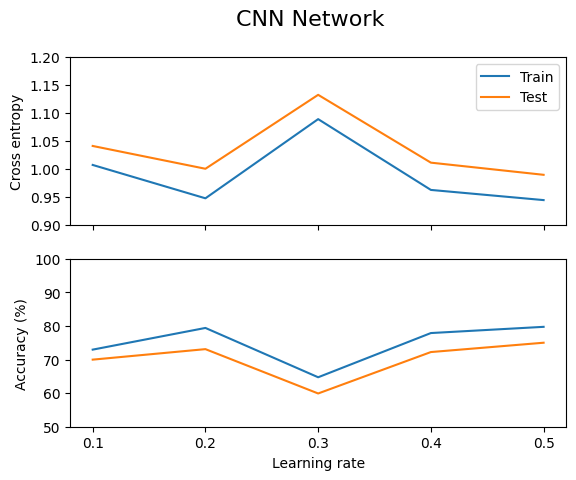

In [ ]:
cnn_cross_accuracy = plt.figure()
fig, ax = plt.subplots(nrows=2, ncols=1, sharex = True)

ax[0].plot(lrs2, results2[0], label = "Train")
ax[0].plot(lrs2, results2[1], label = "Test")

ax[0].legend()

ax[0].set_ylabel("Cross entropy")

ax[1].plot(lrs2, results2[2], label = "Train")
ax[1].plot(lrs2, results2[3], label = "Test")


ax[1].set_xlabel("Learning rate")
ax[1].set_ylabel("Accuracy (%)")

ax[1].set_xticks(lrs2)

ax[0].set(ylim=(0.90, 1.20))
ax[1].set(ylim=(50, 100))

fig.suptitle("CNN Network", fontsize=16)
"""
plt.savefig('cnn_cross_accuracy.pdf')
files.download('cnn_cross_accuracy.pdf')"""

plt.show()

# **Best lr per rete shallow**

In [ ]:
EPOCHS = 30

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

learning_rate = 0.05 #learning rate per rete shallow
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

early_stopping = EarlyStopping(patience=7, verbose=True, path='/content/.checkpoints/model_checkpoint.pt')


for epoch in range(EPOCHS):

  ## TRAIN STEP

  model.train()

  train_loss = 0

  for x_train, y_train in train_loader:

    x_train, y_train = x_train.to(device), y_train.to(device)

    loss = step(model, x_train, y_train, optimizer)

    train_loss += loss

  train_loss /= len(train_loader)
  train_losses.append(train_loss)

  ## TEST STEP

  model.eval()

  train_acc = loader_accuracy(model, train_loader)
  val_acc = loader_accuracy(model, val_loader)

  train_accuracies.append(train_acc)
  val_accuracies.append(val_acc)

  val_loss = evaluate(model, val_loader, early_stopping)
  val_losses.append(val_loss.cpu())

  print("Epoch:", epoch, f"Train: {float(train_acc):.2f}%,  Validation: {float(val_acc):.2f}%,", "Loss_train: ",  f"{float(train_loss):.2f}", "Loss_val: ",  f"{float(val_loss):.2f}")

  if early_stopping.early_stop:
      print("Early stopping triggered.")
      break

No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda'


Epoch: 0 Train: 51.60%,  Validation: 49.31%, Loss_train:  1.31 Loss_val:  1.25
Epoch: 1 Train: 60.86%,  Validation: 54.51%, Loss_train:  1.21 Loss_val:  1.20
Epoch: 2 Train: 66.16%,  Validation: 56.42%, Loss_train:  1.15 Loss_val:  1.17
Epoch: 3 Train: 66.04%,  Validation: 56.60%, Loss_train:  1.11 Loss_val:  1.16
Epoch: 4 Train: 70.97%,  Validation: 60.07%, Loss_train:  1.08 Loss_val:  1.14
Epoch: 5 Train: 72.99%,  Validation: 62.85%, Loss_train:  1.05 Loss_val:  1.13
Epoch: 6 Train: 74.51%,  Validation: 61.98%, Loss_train:  1.03 Loss_val:  1.12
Epochs without improvement: 1
Epoch: 7 Train: 72.12%,  Validation: 60.59%, Loss_train:  1.02 Loss_val:  1.14
Epoch: 8 Train: 78.70%,  Validation: 64.24%, Loss_train:  1.00 Loss_val:  1.11
Epochs without improvement: 1
Epoch: 9 Train: 76.27%,  Validation: 60.76%, Loss_train:  0.98 Loss_val:  1.12
Epoch: 10 Train: 82.40%,  Validation: 64.58%, Loss_train:  0.96 Loss_val:  1.10
Epoch: 11 Train: 83.06%,  Validation: 65.80%, Loss_train:  0.95 Loss_v

In [ ]:
train_losses0 = train_losses
val_losses0 = val_losses
train_accuracies0 = train_accuracies
val_accuracies0 = val_accuracies

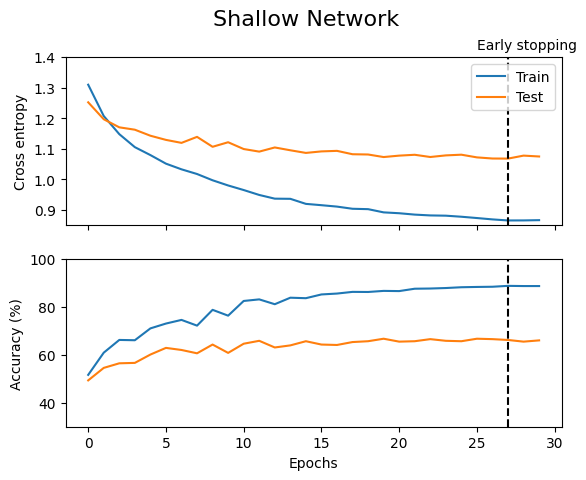

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=1, sharex = True)

ax[0].plot(train_losses0, label = "Train")
ax[0].plot(val_losses0, label = "Test")

ymin, ymax = ax[0].get_ylim()
ax[0].set_ylim(ymin, ymax)
ax[0].vlines(np.argmin(val_losses0), ymin=0.85, ymax=1.4, color = 'black', linestyle = '--')
ax[0].text(x = np.argmin(val_losses0) - 2, y = (ymax+ymin)/2 + 0.34, s = "Early stopping")
ax[0].legend()

ax[0].set_ylabel("Cross entropy")
ax[0].set(ylim=(0.85, 1.4))

ax[1].plot(train_accuracies0, label = "Train")
ax[1].plot(val_accuracies0, label = "Test")
ymin, ymax = ax[1].get_ylim()
ax[1].set_ylim(ymin, ymax)
ax[1].vlines(np.argmin(val_losses0), ymin=30, ymax=100, color = 'black', linestyle = '--', )

ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy (%)")
ax[1].set(ylim=(30,100))


fig.suptitle("Shallow Network", fontsize=16)
"""
plt.savefig('shallow_cross_accuracy.pdf')
files.download('shallow_cross_accuracy.pdf')
"""

plt.show()

# **Best lr per rete FC**

In [ ]:
EPOCHS = 30

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

learning_rate = 0.1
optimizer = torch.optim.SGD(model1.parameters(), lr = learning_rate)

early_stopping = EarlyStopping(patience=7, verbose=True, path='/content/.checkpoints/model_checkpoint.pt')


for epoch in range(EPOCHS):

  ## TRAIN STEP

  model1.train()

  train_loss = 0

  for x_train, y_train in train_loader:

    x_train, y_train = x_train.to(device), y_train.to(device)

    loss = step(model1, x_train, y_train, optimizer)

    train_loss += loss

  train_loss /= len(train_loader)
  train_losses.append(train_loss)

  ## TEST STEP

  model1.eval()

  train_acc = loader_accuracy(model1, train_loader)
  val_acc = loader_accuracy(model1, val_loader)

  train_accuracies.append(train_acc)
  val_accuracies.append(val_acc)

  val_loss = evaluate(model1, val_loader, early_stopping)
  val_losses.append(val_loss.cpu())

  print("Epoch:", epoch, f"Train: {float(train_acc):.2f}%,  Validation: {float(val_acc):.2f}%,", "Loss_train: ",  f"{float(train_loss):.2f}", "Loss_val: ",  f"{float(val_loss):.2f}")

  if early_stopping.early_stop:
      print("Early stopping triggered.")
      break

Epoch: 0 Train: 48.97%,  Validation: 46.53%, Loss_train:  1.31 Loss_val:  1.27
Epoch: 1 Train: 55.14%,  Validation: 49.13%, Loss_train:  1.25 Loss_val:  1.23
Epoch: 2 Train: 58.47%,  Validation: 51.56%, Loss_train:  1.20 Loss_val:  1.21
Epoch: 3 Train: 60.07%,  Validation: 53.65%, Loss_train:  1.18 Loss_val:  1.19
Epochs without improvement: 1
Epoch: 4 Train: 56.78%,  Validation: 50.17%, Loss_train:  1.18 Loss_val:  1.24
Epoch: 5 Train: 63.57%,  Validation: 54.17%, Loss_train:  1.16 Loss_val:  1.18
Epochs without improvement: 1
Epoch: 6 Train: 61.31%,  Validation: 52.43%, Loss_train:  1.14 Loss_val:  1.20
Epoch: 7 Train: 64.51%,  Validation: 55.56%, Loss_train:  1.13 Loss_val:  1.17
Epoch: 8 Train: 66.57%,  Validation: 56.77%, Loss_train:  1.11 Loss_val:  1.17
Epoch: 9 Train: 66.45%,  Validation: 56.42%, Loss_train:  1.10 Loss_val:  1.17
Epochs without improvement: 1
Epoch: 10 Train: 65.95%,  Validation: 56.60%, Loss_train:  1.10 Loss_val:  1.17
Epochs without improvement: 2
Epoch: 11 

In [ ]:
train_losses1 = train_losses
val_losses1 = val_losses
train_accuracies1 = train_accuracies
val_accuracies1 = val_accuracies

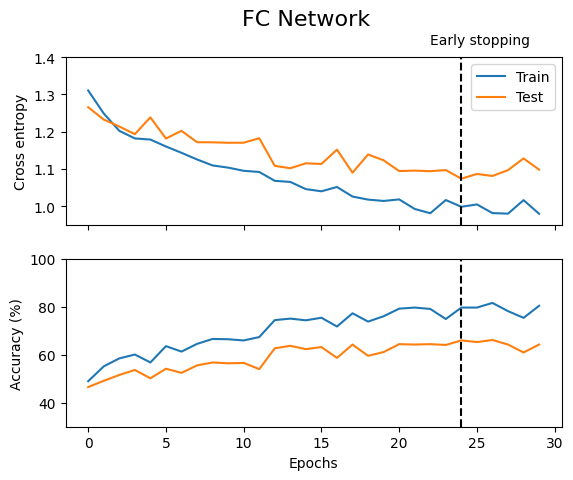

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=1, sharex = True)

ax[0].plot(train_losses1, label = "Train")
ax[0].plot(val_losses1, label = "Test")

ymin, ymax = ax[0].get_ylim()
ax[0].set_ylim(ymin, ymax)
ax[0].vlines(np.argmin(val_losses1), ymin=0.95, ymax=1.4, color = 'black', linestyle = '--')
ax[0].text(x = np.argmin(val_losses1) - 2, y = (ymax+ymin)/2 + 0.29, s = "Early stopping")
ax[0].legend()

ax[0].set_ylabel("Cross entropy")
ax[0].set(ylim=(0.95, 1.4))

ax[1].plot(train_accuracies1, label = "Train")
ax[1].plot(val_accuracies1, label = "Test")
ymin, ymax = ax[1].get_ylim()
ax[1].set_ylim(ymin, ymax)
ax[1].vlines(np.argmin(val_losses1), ymin=30, ymax=100, color = 'black', linestyle = '--', )

ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy (%)")
ax[1].set(ylim=(30,100))

fig.suptitle("FC Network", fontsize=16)

#plt.savefig('FC_cross_accuracy.pdf')
#files.download('FC_cross_accuracy.pdf')

plt.show()

# **Best lr per rete CNN**

In [ ]:
EPOCHS = 30

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

learning_rate = 0.2
optimizer = torch.optim.SGD(model2.parameters(), lr = learning_rate)

early_stopping = EarlyStopping(patience=7, verbose=True, path='/content/.checkpoints/model_checkpoint.pt')


for epoch in range(EPOCHS):

  ## TRAIN STEP

  model2.train()

  train_loss = 0

  for x_train, y_train in train_loader:

    x_train, y_train = x_train.to(device), y_train.to(device)

    loss = step(model2, x_train, y_train, optimizer)

    train_loss += loss

  train_loss /= len(train_loader)
  train_losses.append(train_loss)

  ## TEST STEP

  model2.eval()

  train_acc = loader_accuracy(model2, train_loader)
  val_acc = loader_accuracy(model2, val_loader)

  train_accuracies.append(train_acc)
  val_accuracies.append(val_acc)

  val_loss = evaluate(model2, val_loader, early_stopping)
  val_losses.append(val_loss.cpu())

  print("Epoch:", epoch, f"Train: {float(train_acc):.2f}%,  Validation: {float(val_acc):.2f}%,", "Loss_train: ",  f"{float(train_loss):.2f}", "Loss_val: ",  f"{float(val_loss):.2f}")

  if early_stopping.early_stop:
      print("Early stopping triggered.")
      break

Epoch: 0 Train: 47.66%,  Validation: 44.27%, Loss_train:  1.33 Loss_val:  1.30
Epoch: 1 Train: 52.22%,  Validation: 48.61%, Loss_train:  1.27 Loss_val:  1.24
Epoch: 2 Train: 53.95%,  Validation: 50.52%, Loss_train:  1.23 Loss_val:  1.22
Epoch: 3 Train: 55.88%,  Validation: 52.43%, Loss_train:  1.21 Loss_val:  1.19
Epoch: 4 Train: 61.18%,  Validation: 58.16%, Loss_train:  1.18 Loss_val:  1.17
Epochs without improvement: 1
Epoch: 5 Train: 59.13%,  Validation: 54.34%, Loss_train:  1.15 Loss_val:  1.19
Epochs without improvement: 2
Epoch: 6 Train: 61.76%,  Validation: 55.90%, Loss_train:  1.14 Loss_val:  1.17
Epoch: 7 Train: 67.31%,  Validation: 62.67%, Loss_train:  1.13 Loss_val:  1.11
Epochs without improvement: 1
Epoch: 8 Train: 62.99%,  Validation: 58.33%, Loss_train:  1.11 Loss_val:  1.14
Epochs without improvement: 2
Epoch: 9 Train: 66.08%,  Validation: 60.07%, Loss_train:  1.10 Loss_val:  1.12
Epoch: 10 Train: 70.23%,  Validation: 64.41%, Loss_train:  1.09 Loss_val:  1.09
Epochs wit

In [ ]:
train_losses2 = train_losses
val_losses2 = val_losses
train_accuracies2 = train_accuracies
val_accuracies2 = val_accuracies

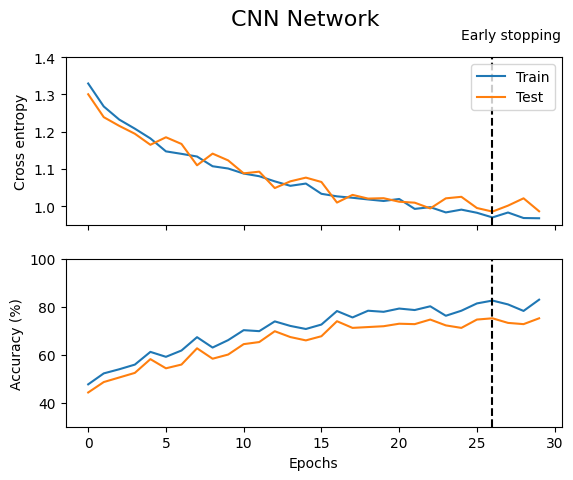

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=1, sharex = True)

ax[0].plot(train_losses2, label = "Train")
ax[0].plot(val_losses2, label = "Test")

ymin, ymax = ax[0].get_ylim()
ax[0].set_ylim(ymin, ymax)
ax[0].vlines(np.argmin(val_losses2), ymin=0.95, ymax=1.4, color = 'black', linestyle = '--')
ax[0].text(x = np.argmin(val_losses2) - 2, y = (ymax+ymin)/2 + 0.3, s = "Early stopping")
ax[0].legend()

ax[0].set_ylabel("Cross entropy")
ax[0].set(ylim=(0.95, 1.4))

ax[1].plot(train_accuracies2, label = "Train")
ax[1].plot(val_accuracies2, label = "Test")
ymin, ymax = ax[1].get_ylim()
ax[1].set_ylim(ymin, ymax)
ax[1].vlines(np.argmin(val_losses2), ymin=30, ymax=100, color = 'black', linestyle = '--', )

ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy (%)")
ax[1].set(ylim=(30,100))

fig.suptitle("CNN Network", fontsize=16)



plt.show()

# **Model interpretation**

# **Rete Shallow**

In [ ]:
from sklearn.metrics import confusion_matrix

model.eval()

all_y = []
all_predictions = []

# Iterate over the dataset
for x, y in val_loader:
    x = x.to(device)

    with torch.no_grad():
        outputs = model(x)
        _, predicted = torch.max(outputs, 1)

    all_y.extend(y.numpy())
    all_predictions.extend(predicted.cpu().numpy())

all_y = np.array(all_y)
all_predictions = np.array(all_predictions)

conf_matrix = confusion_matrix(all_y, all_predictions, normalize = "true")

print(conf_matrix.round(decimals=2))

[[0.71 0.09 0.07 0.13]
 [0.13 0.59 0.08 0.21]
 [0.19 0.08 0.68 0.05]
 [0.27 0.08 0.03 0.63]]


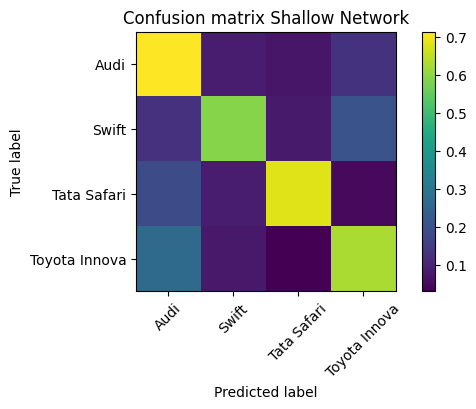

In [ ]:
classes =val_dataset.classes

plt.figure(figsize=(6, 4))
plt.imshow(conf_matrix)
plt.title("Confusion matrix Shallow Network")
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)


plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

plt.show()

In [ ]:
def generate_saliency_map(model, X):

    model.eval()

    saliency_map = []

    for i in range(X.size(0)):

      x = copy.copy(X[i:i+1])  # we create a copy of the image
      x = x.to(device)
      x.requires_grad = True

      output = model(x).squeeze()

      _, target_class = torch.max(output, -1) # we get the predict class (similar to argmax)

      model.zero_grad()
      output[target_class].backward()

      gradients = x.grad

      map, _ = torch.max(gradients.abs().squeeze(), dim=0) # we get the maximum across channels

      saliency_map.append(map.cpu().detach().numpy())
      saliency_map[i] = (saliency_map[i]- saliency_map[i].min())/(saliency_map[i].max() - saliency_map[i].min())  # we scale saliency map in range [0,1]
      x.requires_grad = False

    return np.array(saliency_map)

In [ ]:
examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)

In [ ]:
saliency_map = generate_saliency_map(model, example_data)

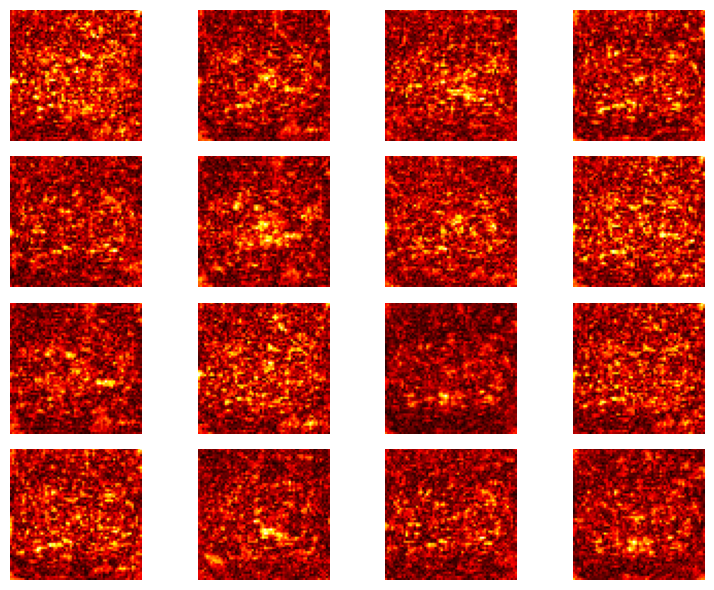

In [ ]:
from matplotlib import colormaps

num_rows = 4
num_cols = 4

colormap = colormaps["hot"] #select a colormap

fig, axes = plt.subplots(num_rows, num_cols, figsize=(8, 6))

for i in range(num_rows):
  for j in range(num_cols):

    img = ((example_data[4*i + j].swapaxes(0,1).swapaxes(1,2)*0.5 + 0.5)* 255).detach().numpy().astype(np.uint8)
    sm = colormap(saliency_map[4*i + j]) # Apply colormap to saliency map

    axes[i, j].imshow(transforms.ToPILImage()(sm))

    axes[i,j].axis('off')

plt.tight_layout()
plt.show()

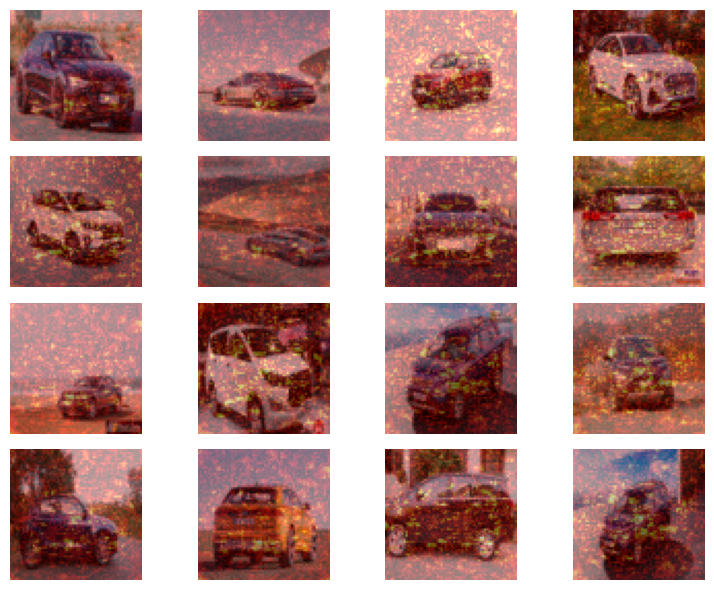

In [ ]:
fig, axes = plt.subplots(num_rows, num_cols, figsize=(8, 6))

for i in range(num_rows):
  for j in range(num_cols):

    img = ((example_data[4*i + j].swapaxes(0,1).swapaxes(1,2)*0.5 + 0.5)* 255).detach().numpy().astype(np.uint8)
    sm = colormap(saliency_map[4*i + j])[:, :, :3]  # Apply colormap to saliency map

    axes[i, j].imshow(Image.blend(Image.fromarray(img), transforms.ToPILImage()(sm), alpha = 0.4))




    axes[i,j].axis('off')

plt.tight_layout()
plt.show()

# **Rete FC**

In [ ]:

model1.eval()

all_y = []
all_predictions = []

# Iterate over the dataset
for x, y in val_loader:
    x = x.to(device)

    with torch.no_grad():
        outputs = model1(x)
        _, predicted = torch.max(outputs, 1)

    all_y.extend(y.numpy())
    all_predictions.extend(predicted.cpu().numpy())

all_y = np.array(all_y)
all_predictions = np.array(all_predictions)

conf_matrix = confusion_matrix(all_y, all_predictions, normalize = "true")

print(conf_matrix.round(decimals=2))

[[0.78 0.05 0.07 0.11]
 [0.24 0.53 0.07 0.17]
 [0.35 0.06 0.55 0.05]
 [0.23 0.07 0.09 0.61]]


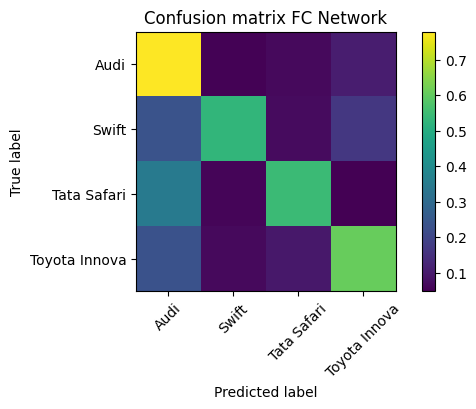

In [ ]:
classes =val_dataset.classes

plt.figure(figsize=(6, 4))
plt.imshow(conf_matrix)
plt.title("Confusion matrix FC Network")
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)


plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

plt.show()

In [ ]:
examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)

In [ ]:
saliency_map = generate_saliency_map(model1, example_data)

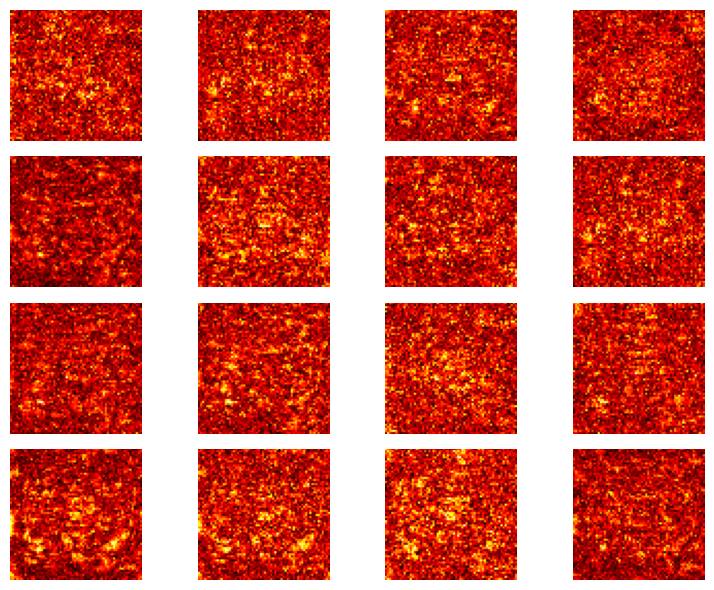

In [ ]:

num_rows = 4
num_cols = 4

colormap = colormaps["hot"] #select a colormap

fig, axes = plt.subplots(num_rows, num_cols, figsize=(8, 6))

for i in range(num_rows):
  for j in range(num_cols):

    img = ((example_data[4*i + j].swapaxes(0,1).swapaxes(1,2)*0.5 + 0.5)* 255).detach().numpy().astype(np.uint8)
    sm = colormap(saliency_map[4*i + j]) # Apply colormap to saliency map

    axes[i, j].imshow(transforms.ToPILImage()(sm))

    axes[i,j].axis('off')

plt.tight_layout()
plt.show()

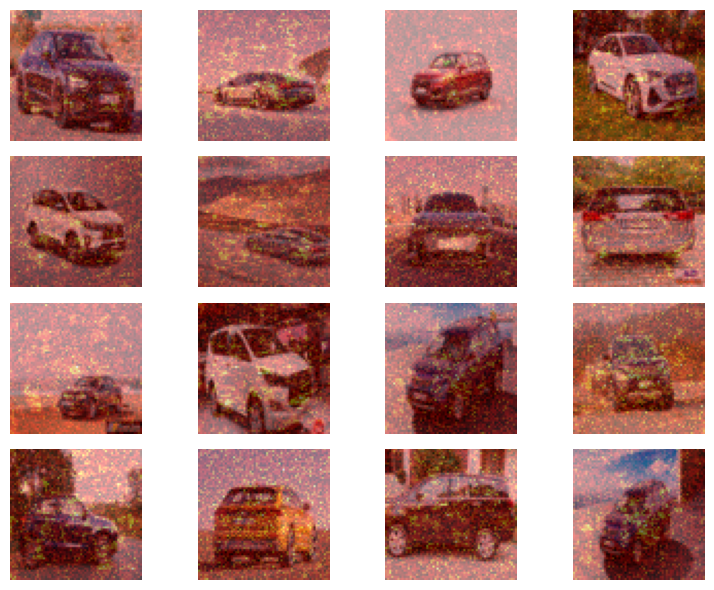

In [ ]:
fig, axes = plt.subplots(num_rows, num_cols, figsize=(8, 6))

for i in range(num_rows):
  for j in range(num_cols):

    img = ((example_data[4*i + j].swapaxes(0,1).swapaxes(1,2)*0.5 + 0.5)* 255).detach().numpy().astype(np.uint8)
    sm = colormap(saliency_map[4*i + j])[:, :, :3]  # Apply colormap to saliency map

    axes[i, j].imshow(Image.blend(Image.fromarray(img), transforms.ToPILImage()(sm), alpha = 0.4))



    axes[i,j].axis('off')

plt.tight_layout()
plt.show()

# **Rete CNN**

In [ ]:
model2.eval()

all_y = []
all_predictions = []

# Iterate over the dataset
for x, y in val_loader:
    x = x.to(device)

    with torch.no_grad():
        outputs = model2(x)
        _, predicted = torch.max(outputs, 1)

    all_y.extend(y.numpy())
    all_predictions.extend(predicted.cpu().numpy())

all_y = np.array(all_y)
all_predictions = np.array(all_predictions)

conf_matrix = confusion_matrix(all_y, all_predictions, normalize = "true")

print(conf_matrix.round(decimals=2))

[[0.78 0.04 0.12 0.07]
 [0.2  0.58 0.07 0.16]
 [0.16 0.05 0.75 0.04]
 [0.11 0.02 0.05 0.82]]


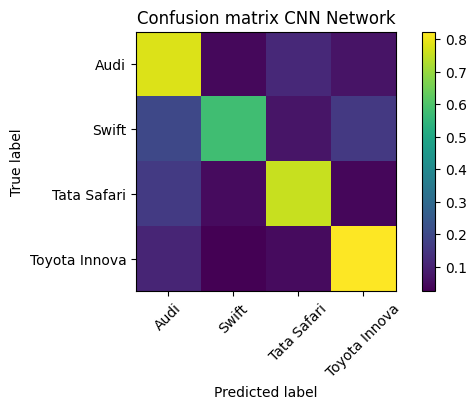

In [ ]:
classes =val_dataset.classes

plt.figure(figsize=(6, 4))
plt.imshow(conf_matrix)
plt.title("Confusion matrix CNN Network")
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)


plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

plt.show()

In [ ]:
examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)

In [ ]:
saliency_map = generate_saliency_map(model2, example_data)

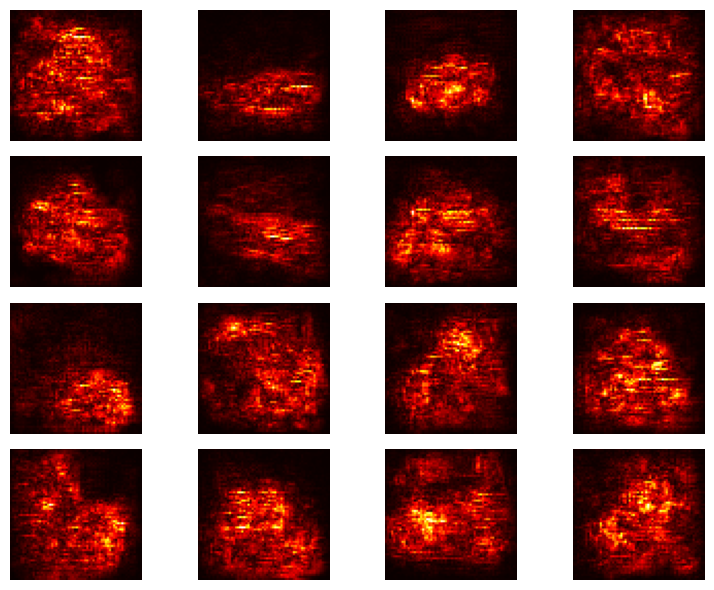

In [ ]:
from matplotlib import colormaps

num_rows = 4
num_cols = 4

colormap = colormaps["hot"] #select a colormap

fig, axes = plt.subplots(num_rows, num_cols, figsize=(8, 6))

for i in range(num_rows):
  for j in range(num_cols):

    img = ((example_data[4*i + j].swapaxes(0,1).swapaxes(1,2)*0.5 + 0.5)* 255).detach().numpy().astype(np.uint8)
    sm = colormap(saliency_map[4*i + j]) # Apply colormap to saliency map

    axes[i, j].imshow(transforms.ToPILImage()(sm))

    axes[i,j].axis('off')

plt.tight_layout()
plt.show()

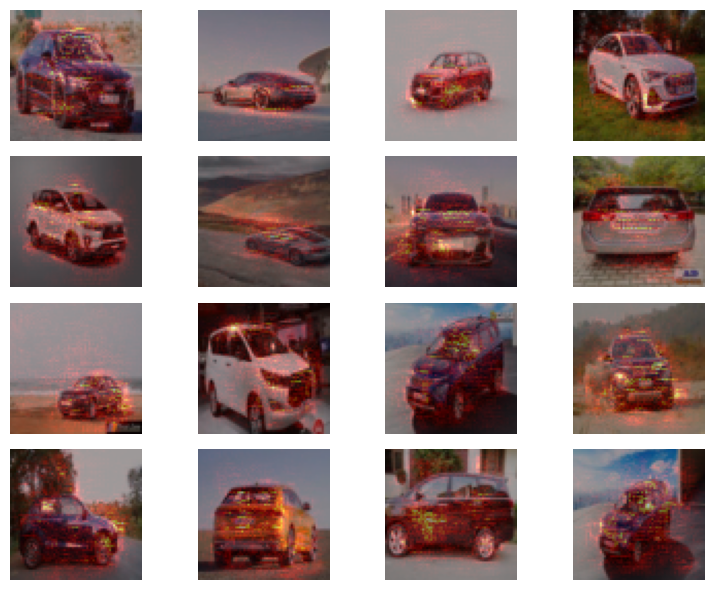

In [ ]:
fig, axes = plt.subplots(num_rows, num_cols, figsize=(8, 6))

for i in range(num_rows):
  for j in range(num_cols):

    img = ((example_data[4*i + j].swapaxes(0,1).swapaxes(1,2)*0.5 + 0.5)* 255).detach().numpy().astype(np.uint8)
    sm = colormap(saliency_map[4*i + j])[:, :, :3]  # Apply colormap to saliency map

    axes[i, j].imshow(Image.blend(Image.fromarray(img), transforms.ToPILImage()(sm), alpha = 0.4))




    axes[i,j].axis('off')

plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

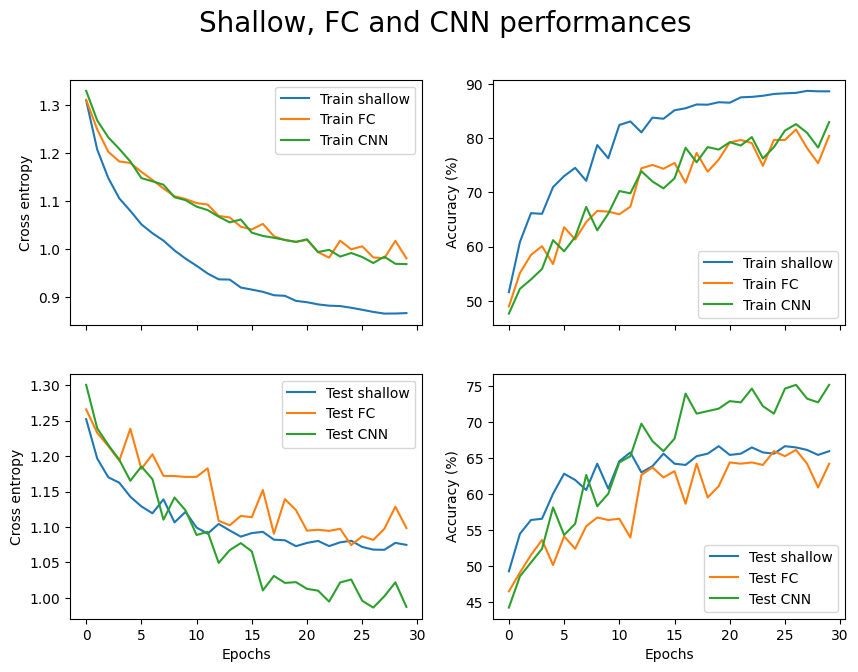

In [ ]:
#GRAFICO COMPLESSIVO TRAINING SET

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=2, figsize = (10, 7), sharex = True)

ax1[0].plot(train_losses0, label = "Train shallow")
ax1[0].plot(train_losses1, label = "Train FC")
ax1[0].plot(train_losses2, label = "Train CNN")

ymin, ymax = ax1[0].get_ylim()
ax1[0].set_ylim(ymin, ymax)
ax1[0].legend()

ax1[0].set_ylabel("Cross entropy")

ax1[1].plot(train_accuracies0, label = "Train shallow")
ax1[1].plot(train_accuracies1, label = "Train FC")
ax1[1].plot(train_accuracies2, label = "Train CNN")

ymin, ymax = ax1[1].get_ylim()
ax1[1].set_ylim(ymin, ymax)
ax1[1].legend()


ax1[1].set_ylabel("Accuracy (%)")

#GRAFICO COMPLESSIVO TEST SET

ax2[0].plot(val_losses0, label = "Test shallow")
ax2[0].plot(val_losses1, label = "Test FC")
ax2[0].plot(val_losses2, label = "Test CNN")

ymin, ymax = ax2[0].get_ylim()
ax2[0].set_ylim(ymin, ymax)
ax2[0].legend()

ax2[0].set_ylabel("Cross entropy")

ax2[1].plot(val_accuracies0, label = "Test shallow")
ax2[1].plot(val_accuracies1, label = "Test FC")
ax2[1].plot(val_accuracies2, label = "Test CNN")

ymin, ymax = ax2[1].get_ylim()
ax2[1].set_ylim(ymin, ymax)
ax2[1].legend()


ax2[0].set_xlabel("Epochs")
ax2[1].set_xlabel("Epochs")
ax2[1].set_ylabel("Accuracy (%)")

fig.suptitle("Shallow, FC and CNN performances", fontsize=20)
plt.savefig("model_performances.pdf")
files.download('model_performances.pdf')

plt.show()